In [1]:
#! /usr/bin/env python
%matplotlib notebook

# import ros stuff
import rospy
import actionlib
import actionlib.msg
import assignment_2_2022.msg
import sys
import select
from std_srvs.srv import *
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2022.msg import Pos_vel

import ipywidgets as widgets
from IPython.display import display
import jupyros as jr
from sensor_msgs.msg import LaserScan

import matplotlib.pyplot as plt
import rospy
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation


global goal, pub
pos_x = 0.0
pos_y = 0.0
x=0
y=0


In [2]:
# initialize the node
rospy.init_node('action_client')

# Publisher: send a message containing the position and velocity
pub = rospy.Publisher("/pos_vel", Pos_vel, queue_size=1)


In [3]:
# Callback function for the subscriber to /odom topic
def callback_pos_vel(msg):

    global pub, pos_x, pos_y, robot_positionX_box, robot_positionY_box

    # Get the position from the msg
    position = msg.pose.pose.position
    
    # Get the velocity from the msg
    velocity = msg.twist.twist.linear
    
    # Create custom message
    pos_vel = Pos_vel()

    # Assign the parameters of the custom message
    pos_vel.x=position.x
    pos_x = position.x
    
    pos_vel.y=position.y
    pos_y = position.y
    
    pos_vel.vel_x=velocity.x
    pos_vel.vel_y=velocity.y

    # Publish the custom message
    pub.publish(pos_vel)
    
    # Update the text boxes with the position informations
    robot_positionX_box.value = pos_x
    robot_positionY_box.value = pos_y
    
    
#Subscriber: get from /odom topic the position and velocity
sub_odom = rospy.Subscriber("/odom", Odometry, callback_pos_vel)

In [4]:
# Create user interface using widgets

robot_positionX_box=widgets.FloatText(value=0.0, description="X Position: ")
robot_positionY_box=widgets.FloatText(value=0.0, description="Y Position: ")


# Update the text boxes with the position and target information in the callback function

display(robot_positionX_box, robot_positionY_box)


FloatText(value=0.0, description='X Position: ')

FloatText(value=0.0, description='Y Position: ')

In [5]:
#Create the client for the action server and the widgets for setting or cancel the goal

def robot_client():
    
    global goal, set_button, cancel_button
    #Create the SimpleActionClient
    client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

    # Wait until the action server is started up
    client.wait_for_server()

    # Create the goal to be sent to the action server
    goal = assignment_2_2022.msg.PlanningGoal()
    
    
    #set the target
    x=widgets.FloatSlider(value=0, min=-10, max=10, step=0.2, description='Set goal x: ', orientation='horizontal')
    y=widgets.FloatSlider(value=0, min=-10, max=10, step=0.2, description='Set goal y: ', orientation='horizontal')
    
    
    
    
    #buttons to set or cancel the goal
    set_button=widgets.Button(description='Click to Set', tooltip='Click to Set')
    set_button.style.button_color = 'green'
    
    cancel_button=widgets.Button(description='Click to Cancel', tooltip='Click to Cancel')
    cancel_button.style.button_color = 'red'
    
    
    # Callback function for the set button: if the goal button is clicked, send the goal to the server
    def on_button_set_clicked(b):
        
        goal.target_pose.pose.position.x = x.value
        goal.target_pose.pose.position.y = y.value
        
        client.send_goal(goal)
         
    set_button.on_click(on_button_set_clicked)
    
    
    
    # Callback function for the cancel button: if the cancel button is clicked, cancel the goal
    def on_cancel_button_clicked(b):
        
        client.cancel_goal() 
        
    cancel_button.on_click(on_cancel_button_clicked)
    
    

    # Create a VBox layout for the sliders and the set button
    sliders_box = widgets.Box([widgets.VBox([x,y])], layout=widgets.Layout(justify_content='flex-start'))
    

    # Create a Box layout to center the buttons
    buttons_box = widgets.Box([widgets.HBox([set_button, cancel_button])], layout=widgets.Layout(justify_content='flex-start'))

    # Display the layouts
    display(sliders_box, buttons_box)

robot_client()


Box(children=(VBox(children=(FloatSlider(value=0.0, description='Set goal x: ', max=10.0, min=-10.0, step=0.2)…

Box(children=(HBox(children=(Button(description='Click to Set', style=ButtonStyle(button_color='green'), toolt…

In [6]:
# Create widgets for distance and angle
distance = widgets.FloatText(description="Obstacle distance:", disabled=True, style={'description_width': 'initial'})
angle = widgets.FloatText(description="Angle:", disabled=True, style={'description_width': 'initial'})

# Initialize the list for laser scanner distances
ranges = []
angles = []

# Callback function for the laser scanner
def laser_callback(scan):
    global ranges, angles
    min_range = 100
    min_angle = 0
    for i, value in enumerate(scan.ranges):
        if value < min_range and value > scan.range_min:
            min_range = value
            min_angle = scan.angle_min + i * scan.angle_increment
    
    ranges = scan.ranges
    angles = [scan.angle_min + i * scan.angle_increment for i in range(len(scan.ranges))]
    distance.value = min_range
    angle.value = min_angle

# Subscribe to the laser scanner topic
jr.subscribe('/scan', LaserScan, laser_callback)

# Display the distance and angle widgets
display(widgets.VBox([distance, angle]))


In [7]:
#Robot Position Plot

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        
        self.ax.set_title("Robot Position Plot")
        self.ax.set_xlabel("position x")  
        self.ax.set_ylabel("position y")
        self.ln, = plt.plot([], [], 'ro')
        self.goal_ln,=plt.plot([],[],'bo', label = 'Goal position', markersize=10)
        self.x_data, self.y_data = [], []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln,self.goal_ln

    def pos_vel_callback(self, pos_vel):
        self.y_data.append(pos_vel.y)
        self.x_data.append(pos_vel.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        self.goal_ln.set_data(goal.target_pose.pose.position.x,goal.target_pose.pose.position.y)
        return self.ln,self.goal_ln


<IPython.core.display.Javascript object>


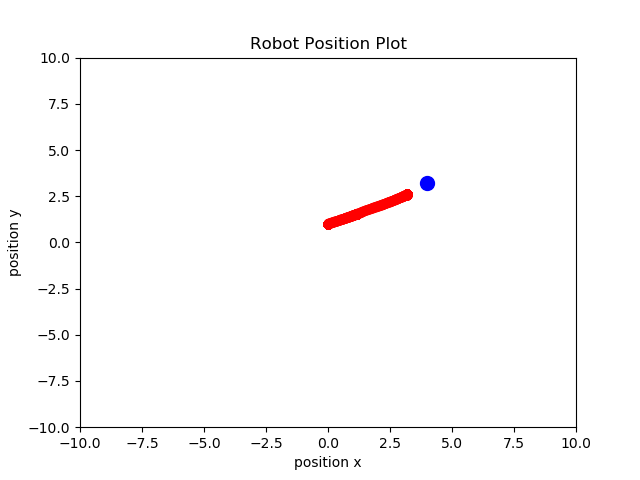

In [8]:
#Visualise the robot position plot

vis = Visualiser()
sub = rospy.Subscriber('/pos_vel', Pos_vel, vis.pos_vel_callback)
ani = FuncAnimation(vis.fig,vis.update_plot, init_func=vis.plot_init, interval=100)

plt.show(block=True)

<IPython.core.display.Javascript object>


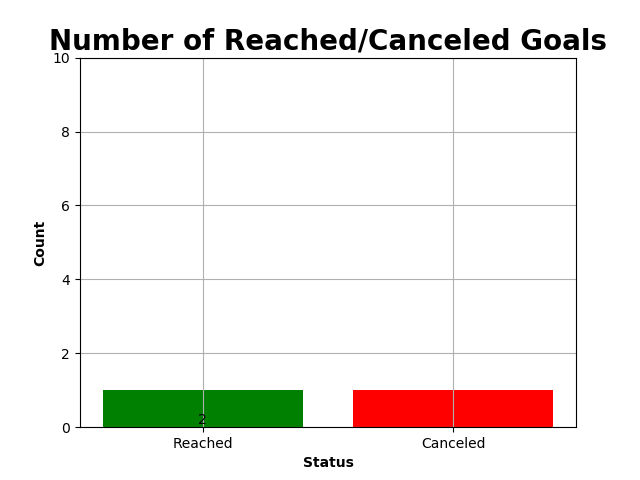

In [9]:
#Visualise in a plot the number of reached and cancelled goals

class GoalVisualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.reached_count = 0
        self.canceled_count = 0

    def init_plot(self):
        self.ax.set_title("Number of Reached/Canceled Goals", fontsize=20, fontweight='bold')
        self.ax.set_xlabel("Status", fontsize=10, fontweight="bold")
        self.ax.set_ylabel("Count", fontsize=10, fontweight="bold")
        self.ax.set_xticks([0, 1])
        self.ax.set_xticklabels(["Reached", "Canceled"])
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)
        self.bar = self.ax.bar([0, 1], [0, 0], color=["green", "red"])
        self.text = self.ax.text(0, 0, "", ha='center', va='bottom')

    def goal_result_callback(self, msg):
        status = msg.status.status
        
        # If status = 3, the goal has been reached
        if status == 3:
            self.reached_count += 1

        # If status = 2, the goal has been canceled
        elif status == 2:
            self.canceled_count += 1

    def update_plot(self, frame):
        self.bar[0].set_height(self.reached_count)
        self.bar[1].set_height(self.canceled_count)
        self.text.set_text(f"{self.reached_count + self.canceled_count}")

# Initialize the GoalVisualizer
vis = GoalVisualizer()

# Set up the ROS subscriber
goal_result_sub = rospy.Subscriber('/reaching_goal/result', assignment_2_2022.msg.PlanningActionResult, vis.goal_result_callback)

# Initialize the plot
vis.init_plot()

# Create the animation
animation = FuncAnimation(vis.fig, vis.update_plot, frames=range(10), blit=False)

# Display the plot
plt.show()
